In [1]:
# !python utils/debug_weights.py integrate checkpoints/local_all/best-checkpoint.ckpt ckpt/init_global.ckpt configs/uni_v15.yaml checkpoints/finetuned_uni_v15.ckpt

In [1]:
import sys
if './' not in sys.path:
	sys.path.append('./')
from utils.share import *
import utils.config as config

import cv2
import einops
import gradio as gr
import numpy as np

import torch
from pytorch_lightning import seed_everything

from annotator.util import resize_image, HWC3
from annotator.canny import CannyDetector
from annotator.mlsd import MLSDdetector
from annotator.hed import HEDdetector
from annotator.sketch import SketchDetector
from annotator.openpose import OpenposeDetector
from annotator.midas import MidasDetector
from annotator.uniformer import UniformerDetector
from annotator.content import ContentDetector

from models.util import create_model, load_state_dict
from models.ddim_hacked import DDIMSampler


apply_canny = CannyDetector()
apply_mlsd = MLSDdetector()
apply_hed = HEDdetector()
apply_sketch = SketchDetector()
apply_openpose = OpenposeDetector()
apply_midas = MidasDetector()
apply_seg = UniformerDetector()
apply_content = ContentDetector()


model = create_model('configs/video_uni_v15/uni_v15.yaml').cpu()
model.load_state_dict(load_state_dict('./checkpoints/video_uni_v15.ckpt', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)


/data/maryam.sana/anaconda3/envs/unicontrol/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


logging improved.
Enabled sliced_attention.
cuda
cuda
Use Checkpoint: False
Checkpoint Number: [0, 0, 0, 0]
Use global window for all blocks in stage3
load checkpoint from local path: /data/maryam.sana/Uni-ControlNet/annotator/ckpts/upernet_global_small.pth
UniControlNet: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Settin

In [2]:
default_num_samples = 4
default_image_resolution = 512
default_strength = 1.0
default_global_strength = 1.0
default_ddim_steps = 50
default_scale = 7.5
default_seed = 42
default_eta = 0.0
default_a_prompt = 'best quality, extremely detailed'
default_n_prompt = ('longbody, lowres, bad anatomy, bad hands, missing fingers, '
                    'extra digit, fewer digits, cropped, worst quality, low quality')

def process(
    seg_image=None, content_image=None, prompt="", 
    a_prompt=default_a_prompt, n_prompt=default_n_prompt, num_samples=default_num_samples, 
    image_resolution=default_image_resolution, ddim_steps=default_ddim_steps, 
    strength=default_strength, scale=default_scale, seed=default_seed, eta=default_eta, 
    global_strength=default_global_strength):
    
    seed_everything(seed)

    if seg_image is not None:
        anchor_image = seg_image
    else:
        anchor_image = np.zeros((image_resolution, image_resolution, 3)).astype(np.uint8)
    
    H, W, C = resize_image(HWC3(anchor_image), image_resolution).shape
    print('in process')
    with torch.no_grad():
        if seg_image is not None:
            seg_image = cv2.resize(seg_image, (W, H))
            seg_detected_map, _ = apply_seg(HWC3(seg_image))
            seg_detected_map = HWC3(seg_detected_map)
        else:
            seg_detected_map = np.zeros((H, W, C)).astype(np.uint8)
        
        if content_image is not None:
            content_emb = apply_content(content_image)
        else:
            content_emb = np.zeros((768))

        detected_maps = seg_detected_map

        local_control = torch.from_numpy(detected_maps.copy()).float().cuda() / 255.0
        local_control = torch.stack([local_control for _ in range(num_samples)], dim=0)
        local_control = einops.rearrange(local_control, 'b h w c -> b c h w').clone()
        global_control = torch.from_numpy(content_emb.copy()).float().cuda().clone()
        global_control = torch.stack([global_control for _ in range(num_samples)], dim=0)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        uc_local_control = local_control
        uc_global_control = torch.zeros_like(global_control)
        cond = {"local_control": [local_control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)], 'global_control': [global_control]}
        un_cond = {"local_control": [uc_local_control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)], 'global_control': [uc_global_control]}
        shape = (4, H // 8, W // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = [strength] * 13
        samples, _ = ddim_sampler.sample(ddim_steps, num_samples,
                                         shape, cond, verbose=False, eta=eta,
                                         unconditional_guidance_scale=scale,
                                         unconditional_conditioning=un_cond, global_strength=global_strength)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
        results = [x_samples[i] for i in range(num_samples)]

    return [results, detected_maps]


In [6]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from utils import *

# Load the image
image_path = 'data/images/j_001.png'
image = Image.open(image_path)
np_image = np.array(image)
prompt = 'The image captures a brown horse galloping across a grassy field. The horse is in motion, with its legs spread apart as it runs. The scene is set against a backdrop of a fence, which adds to the outdoor atmosphere. The horse appears to be enjoying its run, showcasing its speed and agility.'

Global seed set to 42


in process
Data shape for DDIM sampling is (4, 4, 64, 112), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████| 50/50 [01:18<00:00,  1.57s/it]


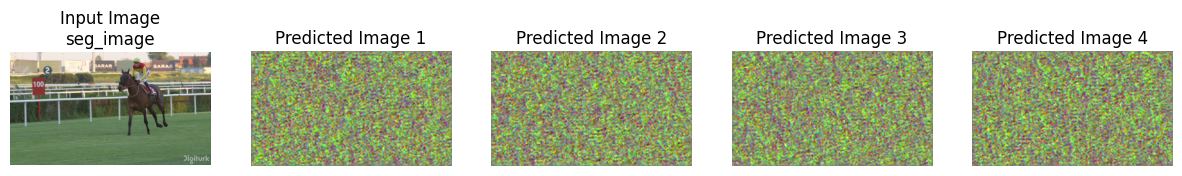

Global seed set to 42


in process
Data shape for DDIM sampling is (4, 4, 64, 112), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler: 100%|███████████████████████████████████████████████| 50/50 [01:18<00:00,  1.58s/it]


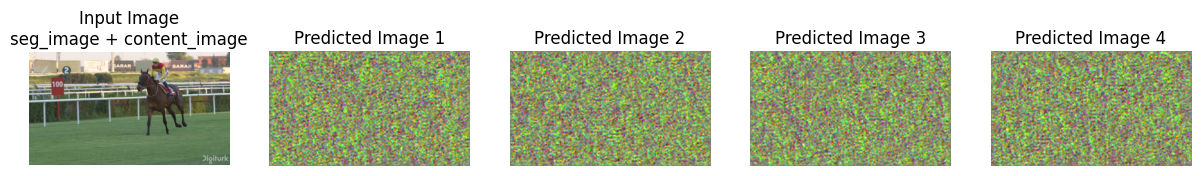

In [7]:
images, maps = process(
    seg_image=np_image,
    prompt=prompt
)
visualize_results(np_image, maps, images, 'seg_image')

# Test condition 2: Using both seg_image and content_image
images, maps = process(
    seg_image=np_image,
    content_image=np_image,
    prompt=prompt
)
visualize_results(np_image, maps, images, 'seg_image + content_image')

In [11]:
# seg_image = np_image
# H, W, C = resize_image(HWC3(seg_image), 512).shape
# seg_image = cv2.resize(seg_image, (W, H))
# seg_detected_map, _ = apply_seg(HWC3(seg_image))
# seg_detected_map = HWC3(seg_detected_map)
# Image.fromarray(seg_detected_map)

In [22]:
psnr_values, ms_ssim_values = calculate_metrics(image, pil_images)

print("PSNR Values:", np.array(psnr_values).mean())
print("MS-SSIM Values:", np.array(ms_ssim_values).mean())


PSNR Values: 11.044816
MS-SSIM Values: 0.24875884130597115


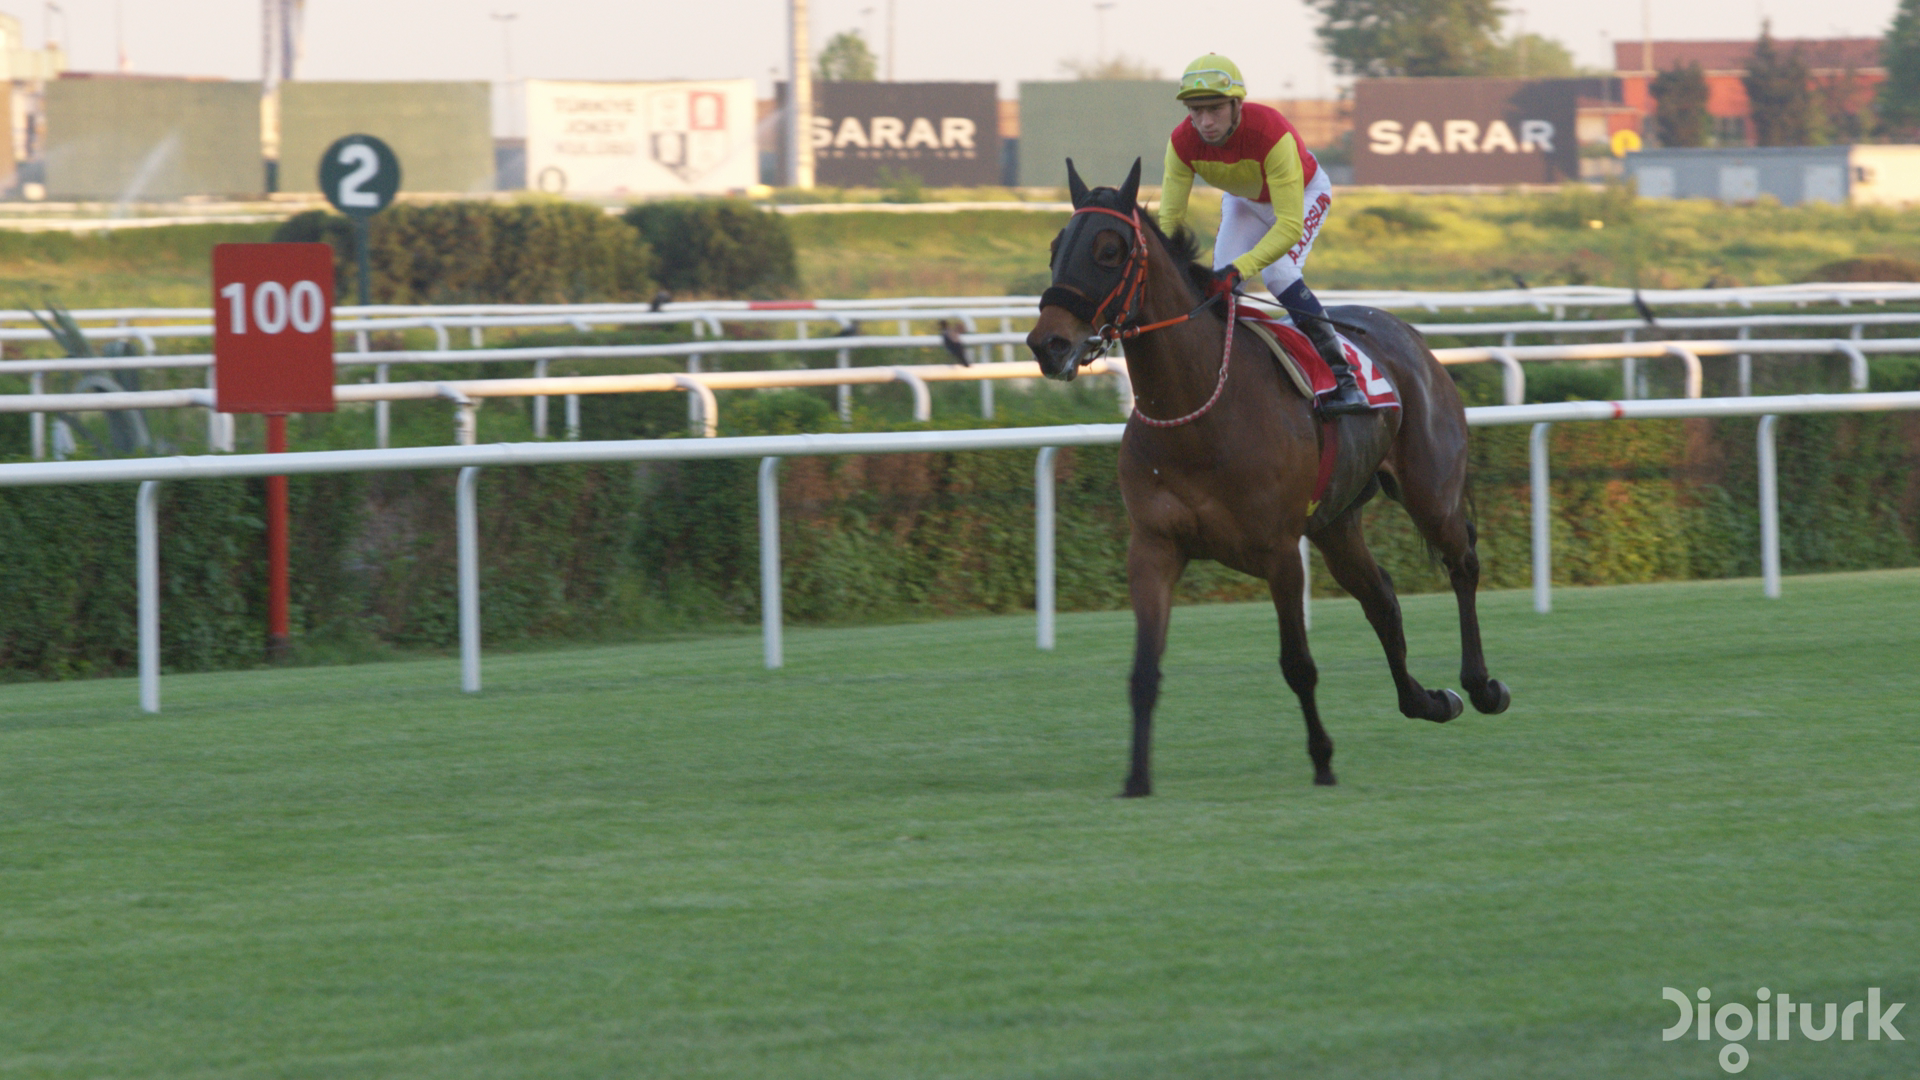

In [23]:
image

In [9]:
image_path = 'data/j_017.png'
image = cv2.imread(image_path)
seg_map = np.array(image)
prompt = 'Jockey on a running horse'

In [10]:
# cv2.resize(seg_map, (W, H)).shape

In [11]:
num_samples = 4
image_resolution = 512
strength = 1.0
global_strength = 1.0
low_threshold = 100
high_threshold = 200
value_threshold = 0.1
distance_threshold = 0.1
alpha = 6.2
ddim_steps = 50
scale = 7.5
seed = 42
eta = 0.0
a_prompt = 'best quality, extremely detailed'
n_prompt = ('longbody, lowres, bad anatomy, bad hands, missing fingers, '
            'extra digit, fewer digits, cropped, worst quality, low quality')
anchor_image = seg_map
H, W, C = resize_image(HWC3(anchor_image), image_resolution).shape
print('in process')
with torch.no_grad():
    canny_detected_map = np.zeros((H, W, C)).astype(np.uint8)
    mlsd_detected_map = np.zeros((H, W, C)).astype(np.uint8)
    hed_detected_map = np.zeros((H, W, C)).astype(np.uint8)
    sketch_detected_map = np.zeros((H, W, C)).astype(np.uint8)
    openpose_detected_map = np.zeros((H, W, C)).astype(np.uint8)
    midas_detected_map = np.zeros((H, W, C)).astype(np.uint8)
    seg_map = cv2.resize(seg_map, (W, H))
    seg_detected_map = HWC3(seg_map)
    content_emb = np.zeros((768))

    detected_maps_list = [canny_detected_map, 
                          mlsd_detected_map, 
                          hed_detected_map,
                          sketch_detected_map,
                          openpose_detected_map,
                          midas_detected_map,
                          seg_detected_map                          
                          ]
    detected_maps = np.concatenate(detected_maps_list, axis=2)

    local_control = torch.from_numpy(detected_maps.copy()).float().cuda() / 255.0
    local_control = torch.stack([local_control for _ in range(num_samples)], dim=0)
    local_control = einops.rearrange(local_control, 'b h w c -> b c h w').clone()
    global_control = torch.from_numpy(content_emb.copy()).float().cuda().clone()
    global_control = torch.stack([global_control for _ in range(num_samples)], dim=0)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    uc_local_control = local_control
    uc_global_control = torch.zeros_like(global_control)
    cond = {"local_control": [local_control], "c_crossattn": [model.get_learned_conditioning([prompt + ', ' + a_prompt] * num_samples)], 'global_control': [global_control]}
    un_cond = {"local_control": [uc_local_control], "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)], 'global_control': [uc_global_control]}
    shape = (4, H // 8, W // 8)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=True)

    model.control_scales = [strength] * 13
    samples, _ = ddim_sampler.sample(ddim_steps, num_samples,
                                                 shape, cond, verbose=False, eta=eta,
                                                 unconditional_guidance_scale=scale,
                                                 unconditional_conditioning=un_cond, global_strength=global_strength)

    if config.save_memory:
        model.low_vram_shift(is_diffusing=False)

    x_samples = model.decode_first_stage(samples)
    x_samples = (einops.rearrange(x_samples, 'b c h w -> b h w c') * 127.5 + 127.5).cpu().numpy().clip(0, 255).astype(np.uint8)
    results = [x_samples[i] for i in range(num_samples)]

in process
Data shape for DDIM sampling is (4, 4, 64, 112), eta 0.0
Running DDIM Sampling with 50 timesteps


DDIM Sampler:  50%|██████████████████████████████                              | 25/50 [00:46<00:46,  1.84s/it]


KeyboardInterrupt: 

In [ ]:
output_images = [Image.fromarray(image) for image in results]

In [ ]:
output_images[1]